In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss)
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    # original_loss = focal_loss(student_outputs[:,0,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0520/weights_KD_segformer_0520_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.8
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.1575

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 719ms/step - loss: 0.1239
Average validation loss: 0.5482060313224792
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 742ms/step - loss: 0.1239 - val_loss: 0.5482
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 786ms/step - loss: 0.0985 - val_loss: 0.5482
Average validation loss: 0.5920488238334656
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 809ms/step - loss: 0.0985 - val_loss: 0.5701
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 842ms/step - loss: 0.0798 - val_loss: 0.5701
Average validation loss: 0.4475991129875183
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 864ms/step - loss: 0.0798 - val_loss: 0.5293
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_5.pth'.
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 782ms/step - loss: 0.0667 - val_loss: 0.5293
Average validation loss: 0.2

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 833ms/step - loss: 0.0113
Average validation loss: 0.4630519598722458
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 849ms/step - loss: 0.0113 - val_loss: 0.4631
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 839ms/step - loss: 0.0105 - val_loss: 0.4631
Average validation loss: 0.1276206523180008
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 849ms/step - loss: 0.0105 - val_loss: 0.2953
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_10.pth'.
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 827ms/step - loss: 0.0101 - val_loss: 0.2953
Average validation loss: 0.13706154376268387
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 841ms/step - loss: 0.0101 - val_loss: 0.2426
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 841ms/step - loss: 0.0096 - val_loss: 0.2426
Average validation loss

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 961ms/step - loss: 0.0060
Average validation loss: 0.3741149653991063
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 974ms/step - loss: 0.0060 - val_loss: 0.3741
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 843ms/step - loss: 0.0053 - val_loss: 0.3741
Average validation loss: 0.05996830482035875
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 858ms/step - loss: 0.0053 - val_loss: 0.2170
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_15.pth'.
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 32s 809ms/step - loss: 0.0049 - val_loss: 0.2170
Average validation loss: 0.06249226195116838
12/12 ━━━━━━━━━━━━━━━━━━━━ 32s 823ms/step - loss: 0.0049 - val_loss: 0.1655
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 43s 947ms/step - loss: 0.0046 - val_loss: 0.1655
Averag

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 837ms/step - loss: 0.0028
Average validation loss: 0.013366139202844352
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 849ms/step - loss: 0.0028 - val_loss: 0.0134
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 804ms/step - loss: 0.0025 - val_loss: 0.0134
Average validation loss: 0.02803224342642352
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 818ms/step - loss: 0.0025 - val_loss: 0.0207
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 822ms/step - loss: 0.0023 - val_loss: 0.0207
Average validation loss: 0.015478600049391389
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 836ms/step - loss: 0.0023 - val_loss: 0.0190
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 53s 820ms/step - loss: 0.0021 - val_loss: 0.0190
Average validation loss: 0.010965388850308955
16/16 ━━━━━━━━━━━━━━━━━━━━ 54s 834ms/step - loss: 0.0021 - val_loss: 0.0170
Saved model weights to 'c:\天_11157065\

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 839ms/step - loss: 0.0038
Average validation loss: 0.02286236993968487
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 850ms/step - loss: 0.0038 - val_loss: 0.0229
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 794ms/step - loss: 0.0030 - val_loss: 0.0229
Average validation loss: 0.009485378861427307
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 806ms/step - loss: 0.0030 - val_loss: 0.0162
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_25.pth'.
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 796ms/step - loss: 0.0026 - val_loss: 0.0162
Average validation loss: 0.0080208501778543
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 808ms/step - loss: 0.0026 - val_loss: 0.0135
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segforme

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 822ms/step - loss: 0.0045
Average validation loss: 0.005812118062749505
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 833ms/step - loss: 0.0045 - val_loss: 0.0058
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 794ms/step - loss: 0.0035 - val_loss: 0.0058
Average validation loss: 0.07243840924153726
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 806ms/step - loss: 0.0035 - val_loss: 0.0391
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 59s 809ms/step - loss: 0.0032 - val_loss: 0.0391
Average validation loss: 0.015631070321736235
24/24 ━━━━━━━━━━━━━━━━━━━━ 59s 821ms/step - loss: 0.0032 - val_loss: 0.0313
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 78s 799ms/step - loss: 0.0028 - val_loss: 0.0313
Average validation loss: 0.02621372463181615
24/24 ━━━━━━━━━━━━━━━━━━━━ 79s 810ms/step - loss: 0.0028 - val_loss: 0.0300
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 9

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 798ms/step - loss: 0.0037
Average validation loss: 0.013504354190081358
40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 810ms/step - loss: 0.0037 - val_loss: 0.0135
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 64s 792ms/step - loss: 0.0029 - val_loss: 0.0135
Average validation loss: 0.022434822795912624
40/40 ━━━━━━━━━━━━━━━━━━━━ 65s 805ms/step - loss: 0.0029 - val_loss: 0.0180
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 96s 782ms/step - loss: 0.0024 - val_loss: 0.0180
Average validation loss: 0.010997842554934323
40/40 ━━━━━━━━━━━━━━━━━━━━ 96s 796ms/step - loss: 0.0024 - val_loss: 0.0156
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_50.pth'.
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 128s 802ms/step - loss: 0.0020 - val_loss: 0.0156
A

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 39s 818ms/step - loss: 0.0023
Average validation loss: 0.00571890189894475
48/48 ━━━━━━━━━━━━━━━━━━━━ 40s 832ms/step - loss: 0.0023 - val_loss: 0.0057
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 81s 860ms/step - loss: 0.0017 - val_loss: 0.0057
Average validation loss: 0.0038963367454319573
48/48 ━━━━━━━━━━━━━━━━━━━━ 82s 874ms/step - loss: 0.0017 - val_loss: 0.0048
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_60.pth'.
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 122s 835ms/step - loss: 0.0014 - val_loss: 0.0048
Average validation loss: 0.005539712755611011
48/48 ━━━━━━━━━━━━━━━━━━━━ 123s 849ms/step - loss: 0.0014 - val_loss: 0.0051
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 162s 820ms/step - loss: 0.0012 - val_loss: 0.0051

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 50s 893ms/step - loss: 0.0014
Average validation loss: 0.047723969644201655
56/56 ━━━━━━━━━━━━━━━━━━━━ 51s 907ms/step - loss: 0.0014 - val_loss: 0.0477
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 96s 805ms/step - loss: 0.0012 - val_loss: 0.0477
Average validation loss: 0.009342187433503568
56/56 ━━━━━━━━━━━━━━━━━━━━ 97s 818ms/step - loss: 0.0012 - val_loss: 0.0285
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_70.pth'.
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 141s 794ms/step - loss: 0.0011 - val_loss: 0.0285
Average validation loss: 0.004172920149617961
56/56 ━━━━━━━━━━━━━━━━━━━━ 142s 808ms/step - loss: 0.0011 - val_loss: 0.0204
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_seg

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 58s 900ms/step - loss: 0.0012
Average validation loss: 0.09458215069025755
64/64 ━━━━━━━━━━━━━━━━━━━━ 58s 913ms/step - loss: 0.0012 - val_loss: 0.0946
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 111s 819ms/step - loss: 0.0012 - val_loss: 0.0946
Average validation loss: 0.00752293890400324
64/64 ━━━━━━━━━━━━━━━━━━━━ 112s 832ms/step - loss: 0.0012 - val_loss: 0.0511
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_80.pth'.
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 164s 808ms/step - loss: 0.0011 - val_loss: 0.0511
Average validation loss: 0.00625883879547473
64/64 ━━━━━━━━━━━━━━━━━━━━ 165s 821ms/step - loss: 0.0011 - val_loss: 0.0361
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segf

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 58s 804ms/step - loss: 0.0011
Average validation loss: 0.010582946223116273
72/72 ━━━━━━━━━━━━━━━━━━━━ 59s 817ms/step - loss: 0.0011 - val_loss: 0.0106
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 124s 905ms/step - loss: 8.6214e-04 - val_loss: 0.0106
Average validation loss: 0.022979312791398518
72/72 ━━━━━━━━━━━━━━━━━━━━ 125s 918ms/step - loss: 8.6214e-04 - val_loss: 0.0168
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 190s 905ms/step - loss: 7.5055e-04 - val_loss: 0.0168
Average validation loss: 0.01857861809791454
72/72 ━━━━━━━━━━━━━━━━━━━━ 191s 918ms/step - loss: 7.5055e-04 - val_loss: 0.0174
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 251s 824ms/step - loss: 8.0409e-04 - val_loss: 0.0174
Average validation loss: 0.014203643992206909
72/72 ━━━━━━━━━━━━━━━━━━━━ 252s 837ms/step - loss: 8.0409e-04 - val_loss: 0.0166
Epoch 5/

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 66s 819ms/step - loss: 9.3884e-04
Average validation loss: 0.003810821413935628
80/80 ━━━━━━━━━━━━━━━━━━━━ 67s 831ms/step - loss: 9.3884e-04 - val_loss: 0.0038
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 132s 817ms/step - loss: 8.2175e-04 - val_loss: 0.0038
Average validation loss: 0.007031115560675971
80/80 ━━━━━━━━━━━━━━━━━━━━ 133s 830ms/step - loss: 8.2175e-04 - val_loss: 0.0054
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 197s 801ms/step - loss: 8.0831e-04 - val_loss: 0.0054
Average validation loss: 0.013347087672445922
80/80 ━━━━━━━━━━━━━━━━━━━━ 198s 814ms/step - loss: 8.0831e-04 - val_loss: 0.0081
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 265s 832ms/step - loss: 7.6670e-04 - val_loss: 0.0081
Average validation loss: 0.004532000704784878
80/80 ━━━━━━━━━━━━━━━━━━━━ 266s 845ms/step - loss: 7.6670e-04 - val_loss: 0.007

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 78s 813ms/step - loss: 0.0014
Average validation loss: 0.022326556189606588
96/96 ━━━━━━━━━━━━━━━━━━━━ 79s 826ms/step - loss: 0.0014 - val_loss: 0.0223
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 156s 798ms/step - loss: 0.0011 - val_loss: 0.0223
Average validation loss: 0.05404723800408343
96/96 ━━━━━━━━━━━━━━━━━━━━ 157s 812ms/step - loss: 0.0011 - val_loss: 0.0382
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 234s 803ms/step - loss: 0.0010 - val_loss: 0.0382
Average validation loss: 0.016313642108192045
96/96 ━━━━━━━━━━━━━━━━━━━━ 236s 817ms/step - loss: 0.0010 - val_loss: 0.0309
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_120.pth'.
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 312s 795ms/step - loss: 9.3273e-04 - val_loss:

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 96s 798ms/step - loss: 0.0020
Average validation loss: 0.030044842177691558
120/120 ━━━━━━━━━━━━━━━━━━━━ 97s 811ms/step - loss: 0.0020 - val_loss: 0.0300
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 198s 839ms/step - loss: 0.0015 - val_loss: 0.0300
Average validation loss: 0.022772654778479288
120/120 ━━━━━━━━━━━━━━━━━━━━ 200s 852ms/step - loss: 0.0015 - val_loss: 0.0264
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_150.pth'.
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 311s 929ms/step - loss: 0.0013 - val_loss: 0.0264
Average validation loss: 0.0072403055596320575
120/120 ━━━━━━━━━━━━━━━━━━━━ 313s 942ms/step - loss: 0.0013 - val_loss: 0.0200
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weigh

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 114s 794ms/step - loss: 0.0016
Average validation loss: 0.004466105677743649
144/144 ━━━━━━━━━━━━━━━━━━━━ 116s 807ms/step - loss: 0.0016 - val_loss: 0.0045
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 231s 794ms/step - loss: 0.0013 - val_loss: 0.0045
Average validation loss: 0.005404637645875078
144/144 ━━━━━━━━━━━━━━━━━━━━ 232s 807ms/step - loss: 0.0013 - val_loss: 0.0049
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 347s 792ms/step - loss: 0.0011 - val_loss: 0.0049
Average validation loss: 0.004082587893208256
144/144 ━━━━━━━━━━━━━━━━━━━━ 348s 805ms/step - loss: 0.0011 - val_loss: 0.0047
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_180.pth'.
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 464s 803ms/step - loss: 0.001

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 127s 795ms/step - loss: 0.0011
Average validation loss: 0.009102509263175306
160/160 ━━━━━━━━━━━━━━━━━━━━ 129s 808ms/step - loss: 0.0011 - val_loss: 0.0091
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 258s 805ms/step - loss: 9.7167e-04 - val_loss: 0.0091
Average validation loss: 0.004240977006702451
160/160 ━━━━━━━━━━━━━━━━━━━━ 260s 818ms/step - loss: 9.7167e-04 - val_loss: 0.0067
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_200.pth'.
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 388s 795ms/step - loss: 8.4564e-04 - val_loss: 0.0067
Average validation loss: 0.006258877101936377
160/160 ━━━━━━━━━━━━━━━━━━━━ 390s 808ms/step - loss: 8.4564e-04 - val_loss: 0.0065
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 517s 793ms/st

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 161s 802ms/step - loss: 0.0011
Average validation loss: 0.045836154731978045
200/200 ━━━━━━━━━━━━━━━━━━━━ 163s 815ms/step - loss: 0.0011 - val_loss: 0.0458
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 327s 819ms/step - loss: 9.5993e-04 - val_loss: 0.0458
Average validation loss: 0.014924413939151861
200/200 ━━━━━━━━━━━━━━━━━━━━ 329s 832ms/step - loss: 9.5993e-04 - val_loss: 0.0304
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_250.pth'.
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 512s 912ms/step - loss: 8.4436e-04 - val_loss: 0.0304
Average validation loss: 0.030923737781712292
200/200 ━━━━━━━━━━━━━━━━━━━━ 514s 925ms/step - loss: 8.4436e-04 - val_loss: 0.0306
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 680s 829ms/st

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 191s 794ms/step - loss: 9.4652e-04
Average validation loss: 0.0034423095178946522
240/240 ━━━━━━━━━━━━━━━━━━━━ 194s 806ms/step - loss: 9.4652e-04 - val_loss: 0.0034
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 384s 792ms/step - loss: 7.8235e-04 - val_loss: 0.0034
Average validation loss: 0.003969918137454916
240/240 ━━━━━━━━━━━━━━━━━━━━ 387s 805ms/step - loss: 7.8235e-04 - val_loss: 0.0037
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 577s 791ms/step - loss: 7.3080e-04 - val_loss: 0.0037
Average validation loss: 0.003516615103530777
240/240 ━━━━━━━━━━━━━━━━━━━━ 580s 804ms/step - loss: 7.3080e-04 - val_loss: 0.0036
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 771s 797ms/step - loss: 6.7938e-04 - val_loss: 0.0036
Average validation loss: 0.003354753650326832
240/240 ━━━━━━━━━━━━━━━━━━━━ 774s 809ms/step - loss: 6.7938e-0

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.20200550481677054, 0.0998562235943973, 0.05894564860345176, 0.01873269018949941, 0.02482645191065967, 0.017875622802239376, 0.017753399656387045, 0.0129680382192358, 0.015571453980082878, 0.006877838917353074, 0.009677823507178497, 0.006097986396489432, 0.010409053572657286, 0.018338944458499703, 0.008515740184188087, 0.00546399987702143, 0.00822906274779037, 0.005408438971398552]
std_val_losses =  [0.1224607816854851, 0.09762259816245457, 0.06686553793042055, 0.015561916269512087, 0.045875894748877426, 0.02392896345893685, 0.036784294642385064, 0.023681474589447624, 0.05262112027911108, 0.013043162605348194, 0.021529721099789876, 0.00902113158829241, 0.012847719116435126, 0.03328212425087087, 0.012659901584224477, 0.004675613423087219, 0.010659657220404172, 0.0071397726569382225]


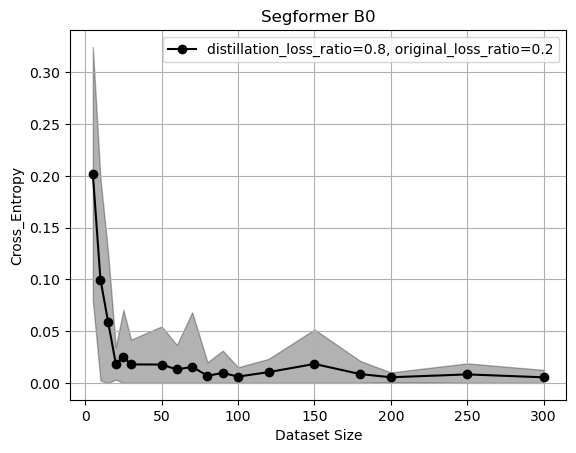

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0520')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0520_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0520_{int(teacher_ratio*100)}.png"))

plt.show()